## Homework - CH 04

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.columns

Index(['lead_source', 'industry', 'number_of_courses_viewed', 'annual_income',
       'employment_status', 'location', 'interaction_count', 'lead_score',
       'converted'],
      dtype='object')

In [5]:
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [6]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [7]:
def fill_missing_values(df):
    numerical = df.select_dtypes(include=['number']).columns
    df[numerical] = df[numerical].fillna(0)

    categorical = df.select_dtypes(include=['object', 'category']).columns
    df[categorical] = df[categorical].fillna('NA')
    
    return df

In [8]:
df = fill_missing_values(df)

In [9]:
df.isnull().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [38]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 1)

In [39]:
y_train = df_train.converted.values
y_val = df_val.converted.values

del df_train['converted']
del df_val['converted']

In [40]:
categorical = ['lead_source', 'industry', 'employment_status', 'location']

numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']

target = 'converted'

### Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.<br>

Let's do that<br>

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.<br>
Use the training dataset for that<br>
If your AUC is < 0.5, invert this variable by putting "-" in front<br>

(e.g. -df_train['balance'])<br>

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.<br>

Which numerical variable (among the following 4) has the highest AUC?<br>

lead_score<br>
number_of_courses_viewed<br>
interaction_count<br>
annual_income<br>

In [25]:
from sklearn.metrics import roc_auc_score

for col in numerical:
    auc = roc_auc_score(y_train, df_train[col])
    print(f"{col}: {auc:.3f}")


number_of_courses_viewed: 0.764
annual_income: 0.552
interaction_count: 0.738
lead_score: 0.614


#### Answer : number_of_courses_viewed

### Question 2

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)<br>
What's the AUC of this model on the validation dataset? (round to 3 digits)

0.32<br>
0.52<br>
0.72<br>
0.92

In [26]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [27]:
from sklearn.metrics import roc_curve
 
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [28]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_val, y_pred)
print(f"AUC: {auc:.3f}")

AUC: 0.817


#### Answer : 0.72

### Question 3 

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01<br>
For each threshold, compute precision and recall<br>
Plot them<br>
At which threshold precision and recall curves intersect?<br>

0.145<br>
0.345<br>
0.545<br>
0.745

In [29]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0, 1, 101)
precisions = []
recalls = []

for t in thresholds:
    y_pred_labels = (y_pred >= t)  
    p = precision_score(y_val, y_pred_labels)
    r = recall_score(y_val, y_pred_labels)
    precisions.append(p)
    recalls.append(r)


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


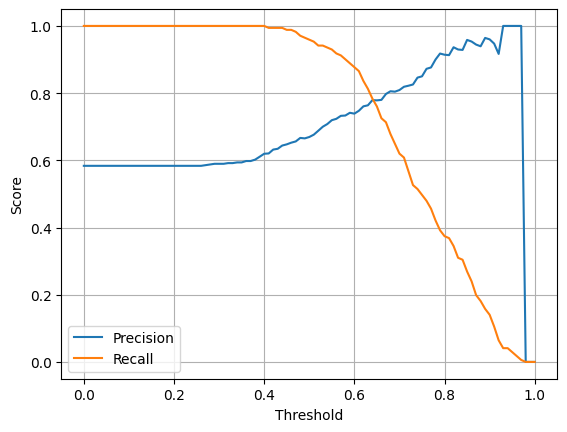

In [30]:
import matplotlib.pyplot as plt

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


#### Answer : 0.745

### Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both<br>

This is the formula for computing F1:<br>
       F1 = 2 (P * R / P+ R)<br>

Where <br>
P is precision and <br>
R is recall.<br>

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01<br>

At which threshold F1 is maximal?<br>

0.14<br>
0.34<br>
0.54<br>
0.74

In [31]:
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for t in thresholds:
    y_pred_bin = (y_pred >= t)
    p = precision_score(y_val, y_pred_bin)
    r = recall_score(y_val, y_pred_bin)
    f1 = 2 * (p * r) / (p + r) if (p + r) != 0 else 0
    f1_scores.append(f1)

best_threshold = thresholds[np.argmax(f1_scores)]
print(f"Best F1 score: {max(f1_scores):.3f} at threshold {best_threshold:.2f}")


Best F1 score: 0.812 at threshold 0.57


/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


#### Answer : 0.54

### Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)<br>
Iterate over different folds of df_full_train<br>
Split the data into train and validation<br>
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)<br>
Use AUC to evaluate the model on validation<br>
How large is standard deviation of the scores across different folds?<br>

0.0001<br>
0.006<br>
0.06<br>
0.36

In [ ]:
def train_model(df_train, y_train, C=1.0):
    train_dict = df_train.to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dict)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

In [ ]:
def predict_model(df, dv, model):
    dicts = df.to_dict(orient='records')
    X = dv.transform(dicts)
    return model.predict_proba(X)[:, 1]

In [41]:
from sklearn.model_selection import KFold

features = [col for col in df_full_train.columns if col != target]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    y_train_fold = df_train_fold[target].values
    y_val_fold = df_val_fold[target].values
    
    dv, model = train_model(df_train_fold[features], y_train_fold)
    y_pred_fold = predict_model(df_val_fold[features], dv, model)
    
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    scores.append(auc)

print(f"Cross-validation scores: {[f'{s:.4f}' for s in scores]}")
mean_score = np.mean(scores)
std_score = np.std(scores)
print(f"Mean: {mean_score:.4f}, Std: {std_score:.4f}")

Cross-validation scores: ['0.8061', '0.8714', '0.7754', '0.8018', '0.8558']
Mean: 0.8221, Std: 0.0358


#### Answer : 0.06

### Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]<br>
Initialize KFold with the same parameters as previously<br>
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)<br>
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)<br>
Which C leads to the best mean score?<br>

0.000001<br>
0.001<br>
1<br>

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [42]:
C_values = [0.000001, 0.001, 1]
results = []

for C in C_values:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]
        
        y_train_fold = df_train_fold[target].values
        y_val_fold = df_val_fold[target].values
        
        dv, model = train_model(df_train_fold[features], y_train_fold, C=C)
        y_pred_fold = predict_model(df_val_fold[features], dv, model)
        
        auc = roc_auc_score(y_val_fold, y_pred_fold)
        scores.append(auc)
    
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    results.append((C, mean_score, std_score))
    print(f"C={C}: Mean AUC = {mean_score:.6f}, Std = {std_score:.6f}")

C=1e-06: Mean AUC = 0.560208, Std = 0.023798
C=0.001: Mean AUC = 0.866878, Std = 0.028746
C=1: Mean AUC = 0.822109, Std = 0.035807


#### Answer : 0.001